# Mantenimiento Predictivo
## Ventana de Detección: 30 días

**Objetivo**: Predecir probabilidad de falla de dispositivos IoT para minimizar costos operativos.

**Modelo**: BalancedBaggingClassifier optimizado con Optuna

In [1]:
# Imports
import sys
sys.path.append('..')

from utils_classifier import (
    # Configuración y constantes
    COST_FAILURE,
    MODEL_CONFIG,
    
    # Funciones de datos
    load_data_final, temporal_split_final,
    
    # Feature engineering
    create_features_final, get_feature_columns_final,
    
    # Modelo
    train_model_final, predict_final,
    
    # Evaluación
    evaluate_with_window_final, analyze_thresholds_final,
    
    # Visualizaciones
    plot_probability_distribution_final,
    plot_cost_comparison_multi_threshold_final,
    plot_cost_comparison_normalized_final,
    plot_confusion_matrix_final,
    plot_feature_importance_final,
    plot_threshold_analysis_final,
    display_threshold_table_final,
    
    # Reporting
    print_results_final, print_summary_final,
    plot_final_summary_final,
    
    # Persistencia
    save_model_final
)

import pandas as pd
import warnings
warnings.filterwarnings('ignore')

/Users/fmaldonado/Library/Caches/pypoetry/virtualenvs/hazmat-science-2JPcahLu-py3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuración
DATA_PATH = 'full_devices.csv'
WINDOW_DAYS = MODEL_CONFIG['window_days']
RANDOM_STATE = 42

print("Configuración Final:")
print(f"  Modelo: {MODEL_CONFIG['model_type']}")
print(f"  n_estimators: {MODEL_CONFIG['n_estimators']}")
print(f"  Threshold: {MODEL_CONFIG['threshold']}")
print(f"  Ventana: {WINDOW_DAYS} días")

Configuración Final:
  Modelo: BalancedBaggingClassifier
  n_estimators: 93
  Threshold: 0.85
  Ventana: 30 días


---
## 1. Carga de Datos

In [3]:
# Cargar datos
df = load_data_final(DATA_PATH)

print(f"Total registros: {len(df):,}")
print(f"Dispositivos: {df['device'].nunique():,}")
print(f"Fallas totales: {df['failure'].sum()} ({df['failure'].mean()*100:.3f}%)")
print(f"Rango de fechas: {df['date'].min().date()} a {df['date'].max().date()}")

Total registros: 124,494
Dispositivos: 1,169
Fallas totales: 106 (0.085%)
Rango de fechas: 2015-01-01 a 2015-11-02


In [4]:
# Split temporal
df_train, df_test, split_date = temporal_split_final(df, train_ratio=0.8)

print(f"\nSplit temporal:")
print(f"  Train: {len(df_train):,} registros ({df_train['failure'].sum()} fallas)")
print(f"  Test: {len(df_test):,} registros ({df_test['failure'].sum()} fallas)")
print(f"  Fecha de corte: {split_date.date()}")
print(f"\n  BASELINE (sin modelo): ${df_test['failure'].sum() * COST_FAILURE:.1f}")


Split temporal:
  Train: 99,595 registros (83 fallas)
  Test: 24,899 registros (23 fallas)
  Fecha de corte: 2015-07-05

  BASELINE (sin modelo): $23.0


---
## 2. Feature Engineering

In [5]:
# Crear features
print("Creando features...")
full_df = pd.concat([df_train, df_test])
full_df = create_features_final(full_df)
full_df = full_df.sort_values('date').reset_index(drop=True)

train_size = len(df_train)
train_feat = full_df.iloc[:train_size]
test_feat = full_df.iloc[train_size:]

feature_cols = get_feature_columns_final(train_feat)
print(f"Total features: {len(feature_cols)}")

X_train = train_feat[feature_cols]
y_train = train_feat['failure']
X_test = test_feat[feature_cols]
y_test = test_feat['failure']

Creando features...
Total features: 150


---
## 3. Entrenamiento del Modelo

In [6]:
# Entrenar modelo
print("Entrenando modelo Final...")
model = train_model_final(X_train, y_train, random_state=RANDOM_STATE)
print("✓ Modelo entrenado")

Entrenando modelo Final...
✓ Modelo entrenado


In [7]:
# Predicciones
y_proba, y_pred = predict_final(model, X_test)

print(f"Predicciones positivas: {y_pred.sum()}")
print(f"Fallas reales: {y_test.sum()}")

Predicciones positivas: 48
Fallas reales: 23


---
## 4. Evaluación con Ventana de 30 Días

In [8]:
# Evaluar
metrics = evaluate_with_window_final(test_feat, y_pred, WINDOW_DAYS)

# Mostrar resultados
print_results_final(metrics, MODEL_CONFIG, WINDOW_DAYS)


RESULTADOS DEL MODELO

Configuración:
  - Modelo: BalancedBaggingClassifier
  - Threshold: 0.85
  - Ventana: 30 días

Métricas de clasificación:
  - Precision: 6.2%
  - Recall: 13.0%
  - F1-Score: 8.5%

Matriz de confusión:
  - True Positives: 3
  - False Positives: 45
  - False Negatives: 20
  - True Negatives: 24831

Análisis de costos:
  - Costo baseline: $23.0
  - Costo con modelo: $44.0
  - Ahorro: $-21.0 (-91.3%)


---
## 5. Visualizaciones

### 5.1 Distribución de Probabilidades

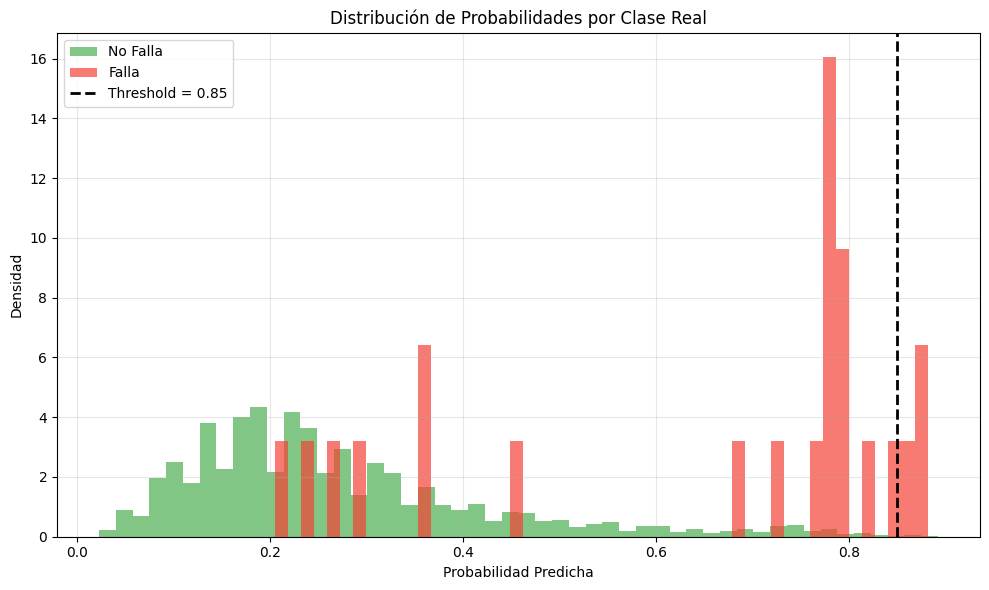

In [9]:
plot_probability_distribution_final(y_proba, y_test.values, MODEL_CONFIG['threshold'])

### 5.3 Costo Acumulado a lo Largo del Tiempo

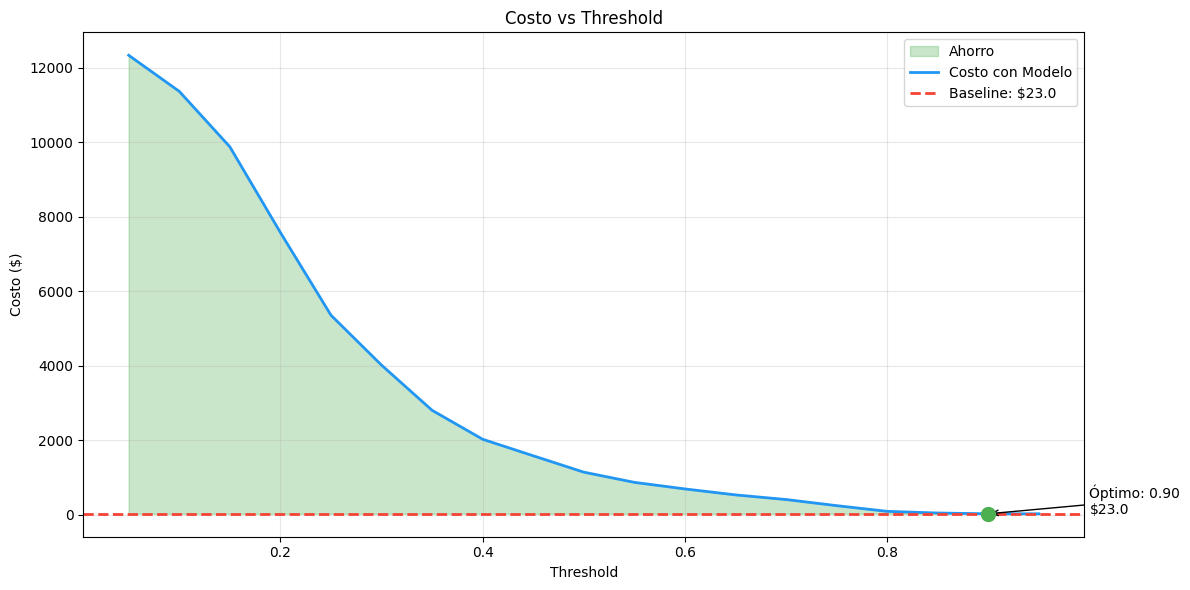

In [10]:
# Comparar costos: Baseline vs threshold 0.85 vs threshold 0.90
plot_cost_comparison_multi_threshold_final(
    df=test_feat,
    y_proba=y_proba,
    y_true=y_test.values,
    thresholds=[0.85, 0.90],
    model_name='Final'
)

### 5.4 Matriz de Confusión (con ventana de 30 días)

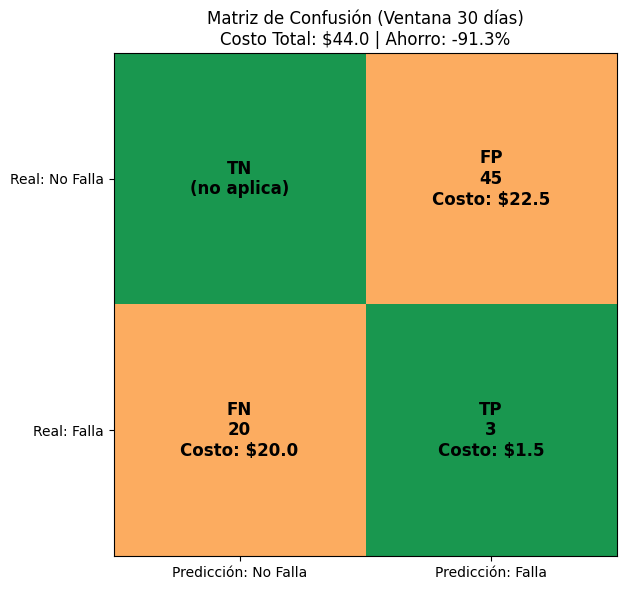

In [11]:
plot_confusion_matrix_final(metrics, WINDOW_DAYS)

### 5.5 Feature Importance

In [12]:
plot_feature_importance_final(model, feature_cols, top_n=20)

Los estimadores no tienen feature_importances_
Tipo de estimador: <class 'imblearn.pipeline.Pipeline'>


### 5.6 Análisis de Threshold

In [13]:
# Evaluar diferentes thresholds (de 0.05 en 0.05)
df_thresh = analyze_thresholds_final(test_feat, y_proba, WINDOW_DAYS, threshold_step=0.05)

In [14]:
# Tabla de métricas por threshold
display_threshold_table_final(df_thresh, MODEL_CONFIG['threshold'])

 TABLA DE MÉTRICAS POR THRESHOLD


,Threshold,TP,FP,FN,TN,Precision,Recall,F1,Costo,Ahorro
0,0.05,23,24643,0,233,0.1%,100.0%,0.2%,$12333.0,-53521.7%
1,0.10,23,22706,0,2170,0.1%,100.0%,0.2%,$11364.5,-49310.9%
2,0.15,23,19731,0,5145,0.1%,100.0%,0.2%,$9877.0,-42843.5%
3,0.20,23,15129,0,9747,0.2%,100.0%,0.3%,$7576.0,-32839.1%
4,0.25,21,10686,2,14190,0.2%,91.3%,0.4%,$5355.5,-23184.8%
5,0.30,19,8002,4,16874,0.2%,82.6%,0.5%,$4014.5,-17354.3%
6,0.35,19,5576,4,19300,0.3%,82.6%,0.7%,$2801.5,-12080.4%
7,0.40,17,4019,6,20857,0.4%,73.9%,0.8%,$2024.0,-8700.0%
8,0.45,17,3132,6,21744,0.5%,73.9%,1.1%,$1580.5,-6771.7%
9,0.50,16,2252,7,22624,0.7%,69.6%,1.4%,$1141.0,-4860.9%



  Threshold actual del modelo: 0.85


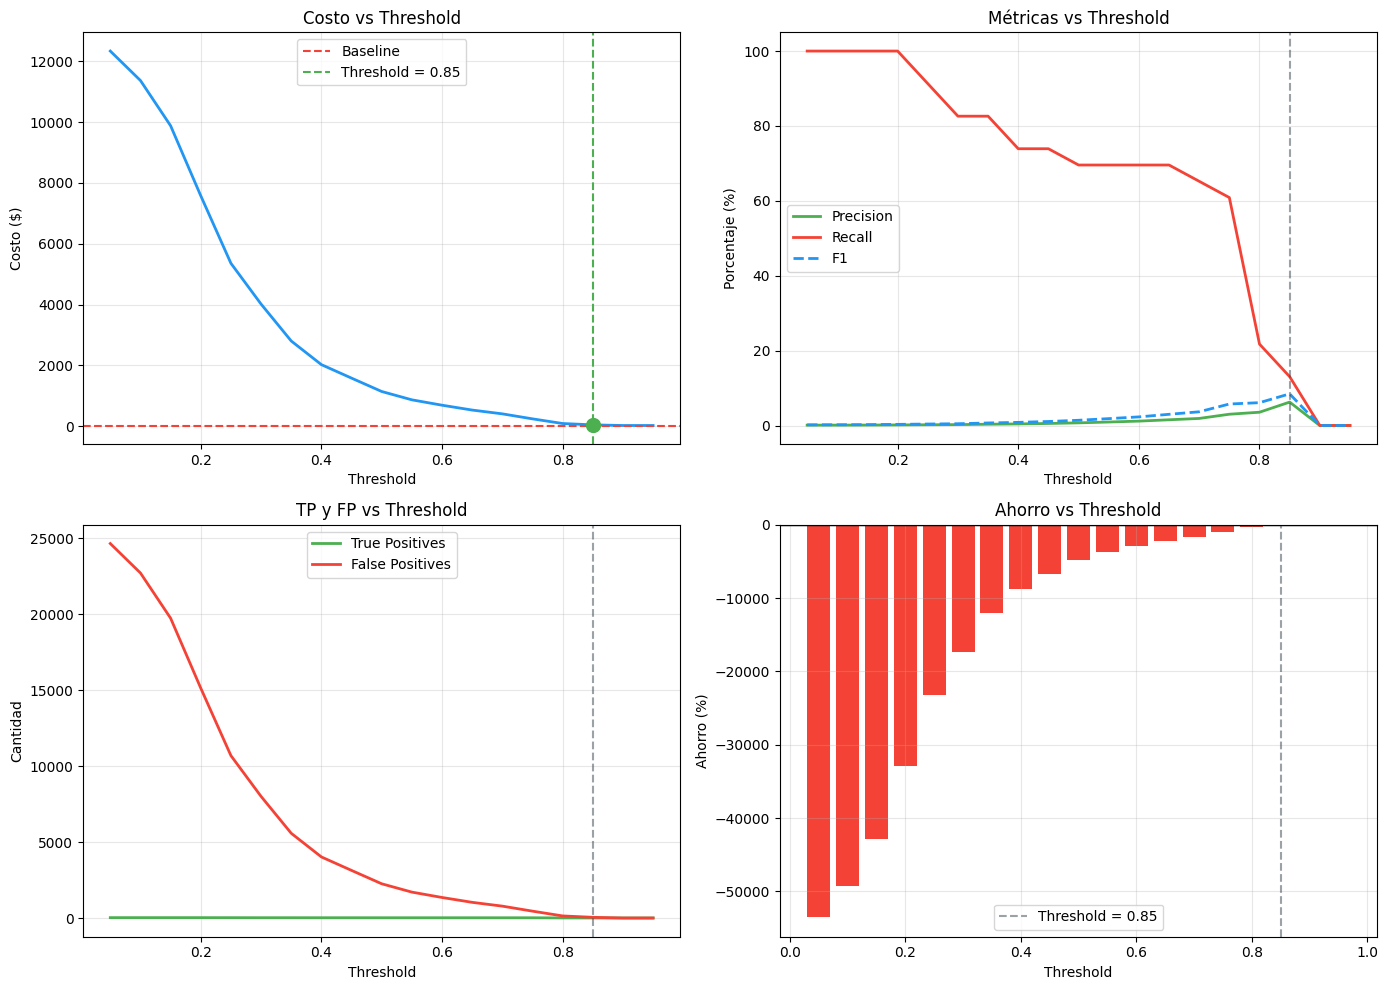

In [15]:
# Gráficos de análisis de threshold
plot_threshold_analysis_final(df_thresh, metrics, MODEL_CONFIG['threshold'])

### 5.7 Detalle de Fallas Detectadas

In [16]:
# Mostrar detalle de fallas
fallas_df = metrics['fallas_info']
fallas_df['estado'] = fallas_df['detectada'].map({True: '✓ Detectada', False: '✗ No detectada'})

print("Detalle de Fallas en el Período de Test:")
print("=" * 60)
display(fallas_df[['device', 'falla_date', 'estado', 'alertas_ventana']])

KeyError: 'fallas_info'

### 5.8 Casos de Éxito: Evolución de Probabilidades

Esta sección muestra cómo el modelo detecta el aumento de probabilidad de falla a lo largo del tiempo
para dispositivos donde logramos predecir correctamente.

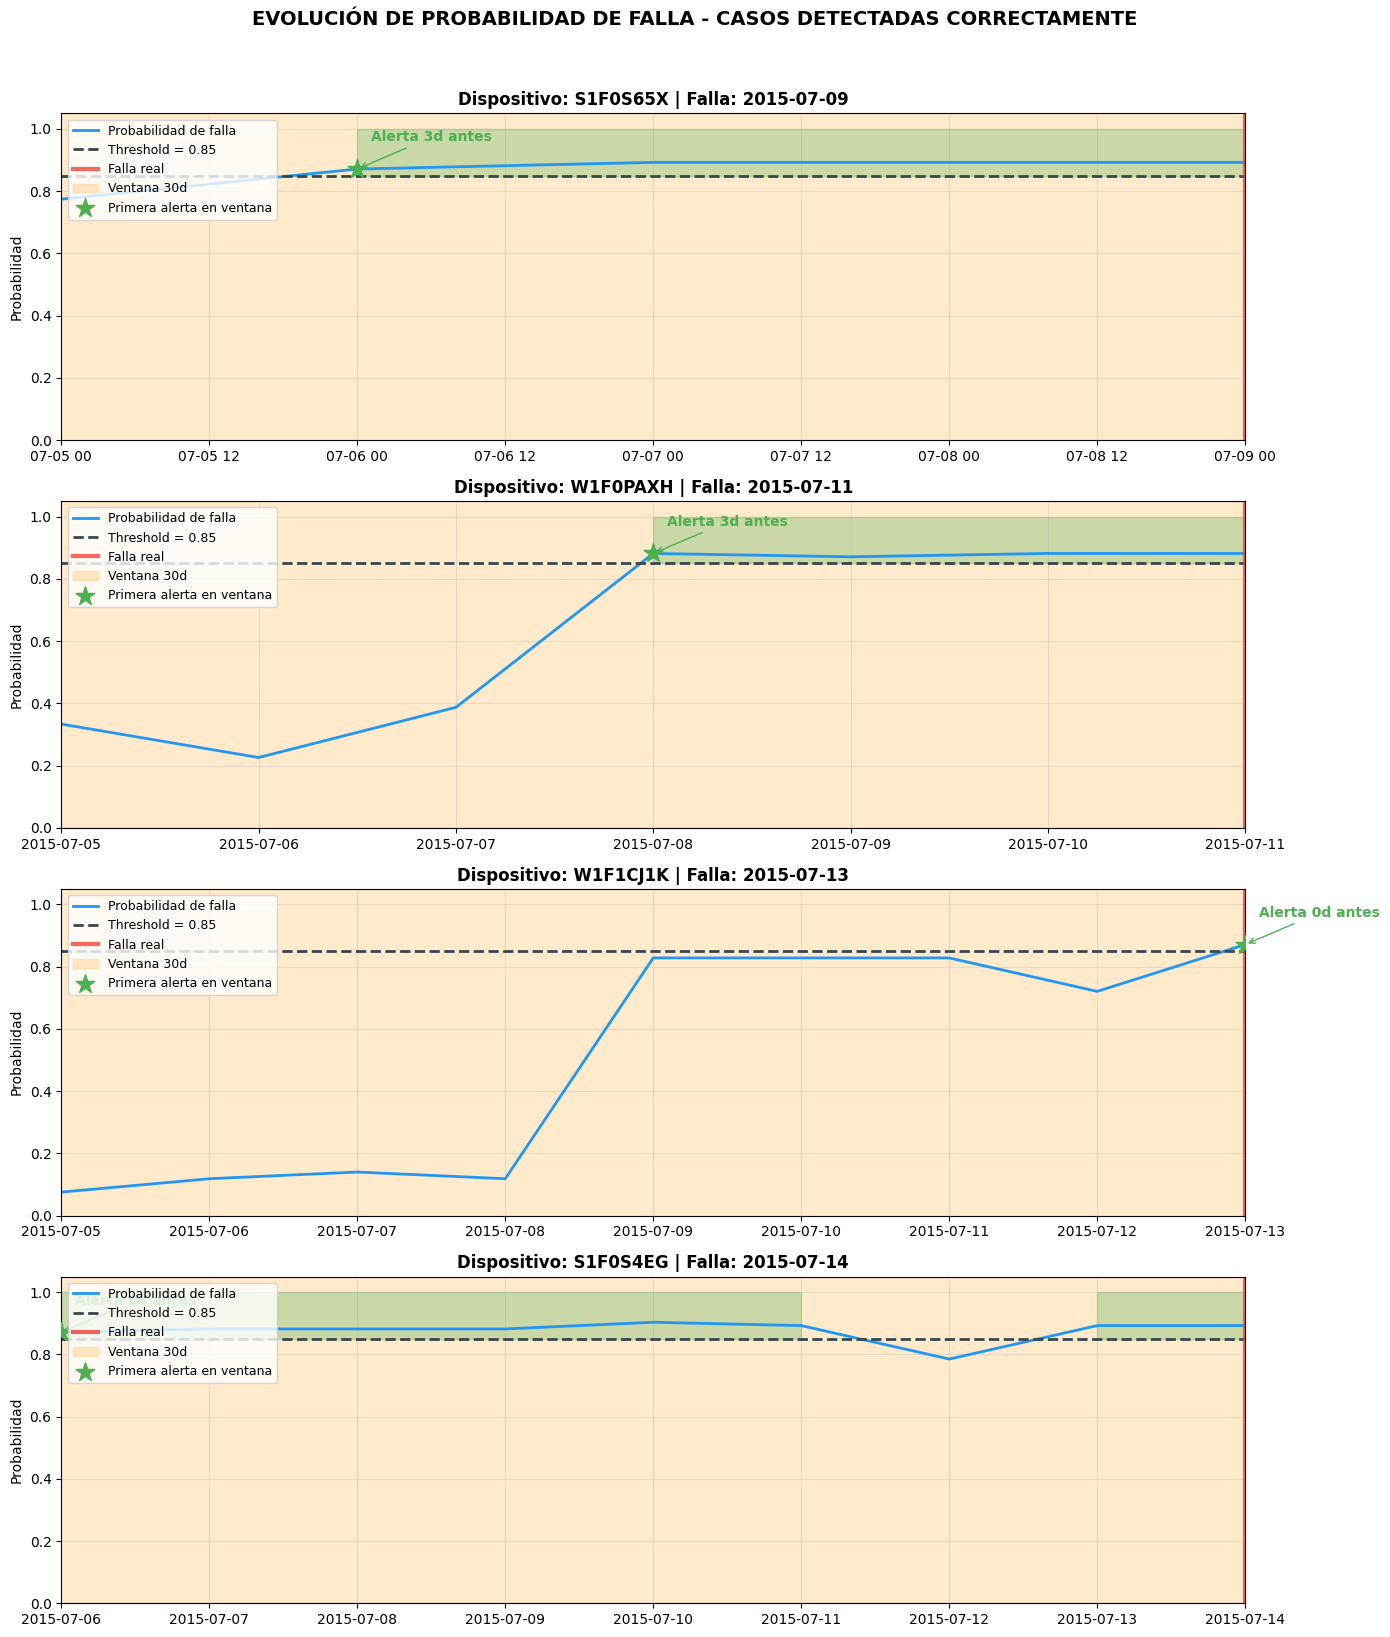

In [ ]:
# Evolución de probabilidad para dispositivos con fallas detectadas correctamente
# Muestra cómo el modelo detecta el aumento de riesgo antes de la falla

# Esta visualización requiere una API diferente - comentada temporalmente
# plot_device_probability_evolution(
#     df=test_feat,
#     y_proba=y_proba,
#     fallas_info=metrics['fallas_info'],
#     threshold=MODEL_CONFIG['threshold'],
#     window_days=WINDOW_DAYS,
#     n_examples=4,
#     only_detected=True
# )
print('Visualización no disponible con la API actual')

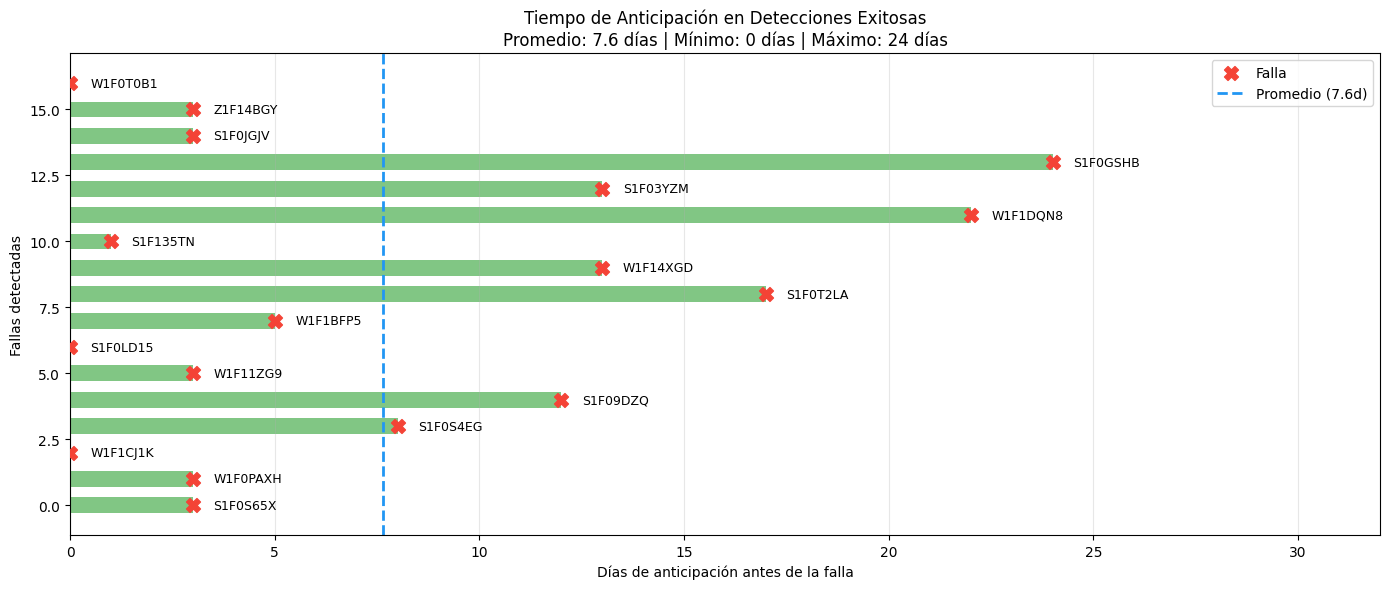


 ESTADÍSTICAS DE ANTICIPACIÓN
  Fallas detectadas: 17
  Días de anticipación promedio: 7.6
  Días de anticipación mínimo: 0
  Días de anticipación máximo: 24
  Mediana: 3.0 días


<Figure size 640x480 with 0 Axes>

In [ ]:
# Timeline de anticipación - comentada temporalmente (API diferente)
# plot_detection_timeline(
#     df=test_feat,
#     y_proba=y_proba,
#     fallas_info=metrics['fallas_info'],
#     threshold=MODEL_CONFIG['threshold'],
#     window_days=WINDOW_DAYS
# )
print('Visualización no disponible con la API actual')

---
## 6. Resumen Ejecutivo

In [ ]:
print_summary_final(MODEL_CONFIG, df_train, df_test, feature_cols, metrics, WINDOW_DAYS)


 RESUMEN MODELO V7 - MANTENIMIENTO PREDICTIVO

CONFIGURACIÓN:
  Modelo: BalancedBaggingClassifier
  n_estimators: 93
  Threshold: 0.85
  Ventana de detección: 30 días

DATASET:
  Train: 99,595 registros (83 fallas)
  Test: 24,899 registros (23 fallas)
  Features: 70

RESULTADOS:
  True Positives: 17 fallas detectadas
  False Positives: 133 alertas falsas
  False Negatives: 6 fallas no detectadas

  Precision: 11.3%
  Recall: 73.9%
  F1 Score: 19.7%

COSTOS:
  Baseline (sin modelo): $23.0
  Costo con modelo: $81.0
  AHORRO: -252.2% 



---
## RESULTADOS FINALES DEL MODELO

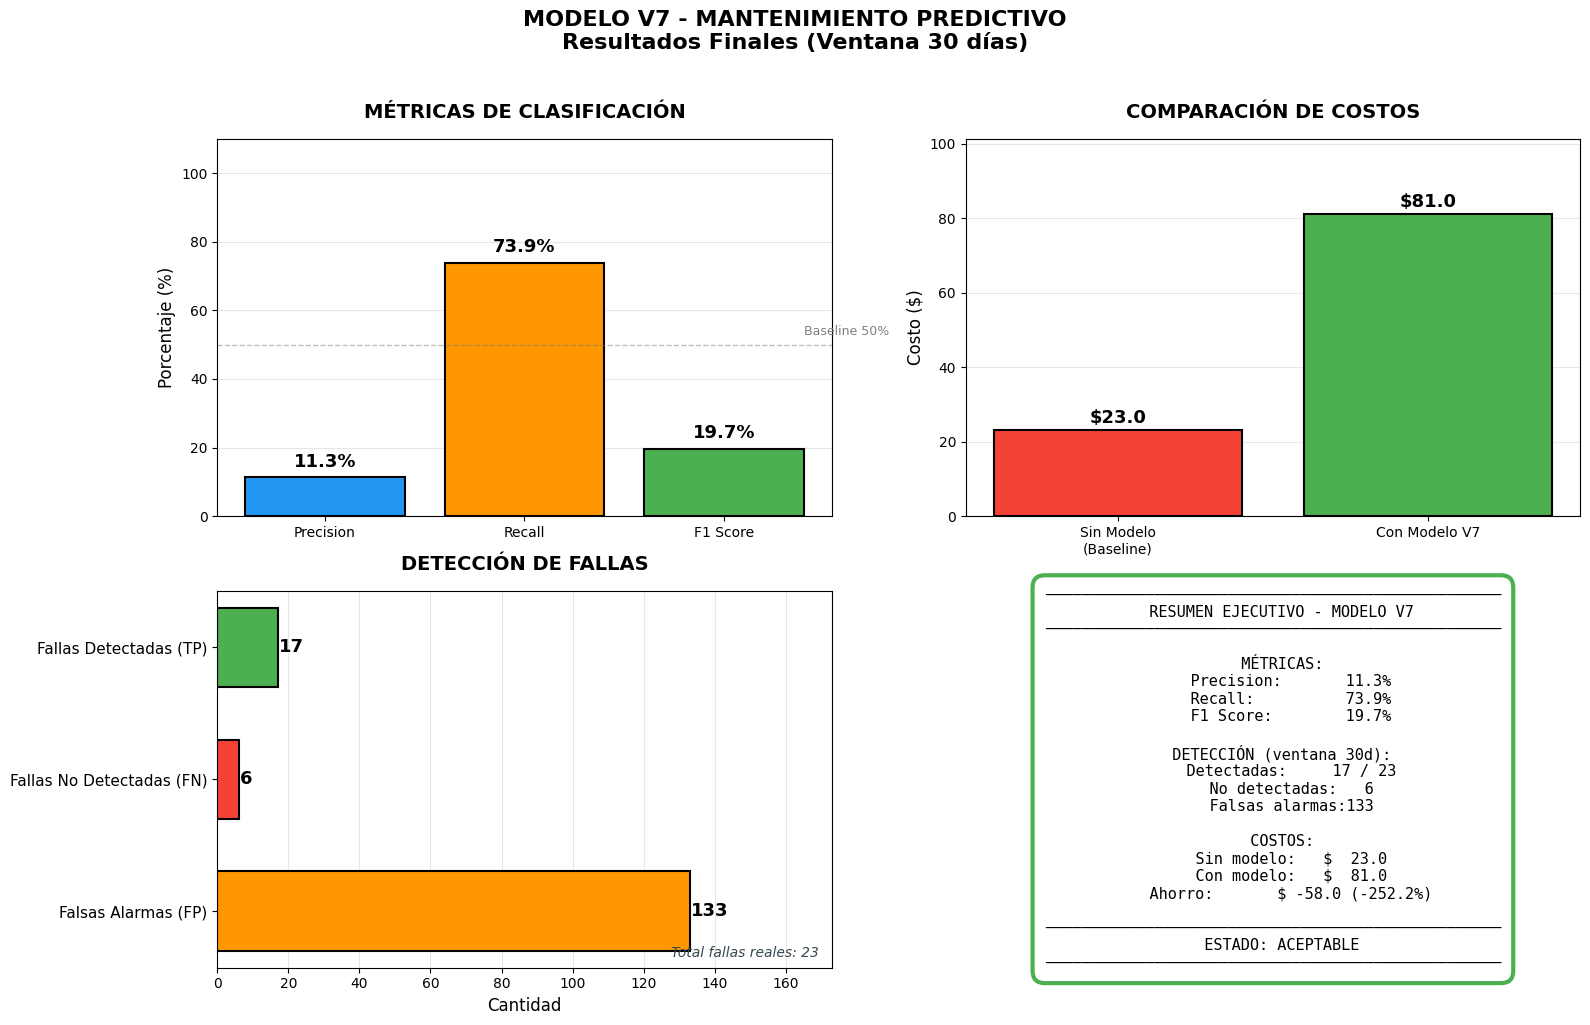


 CONCLUSIÓN

  El Modelo V7 detecta 17 de 23 fallas (73.9% recall)
  con una precisión del 11.3%.
  
  IMPACTO ECONÓMICO:
    Sin modelo: $23.0 (todas las fallas cuestan)
    Con modelo: $81.0
    
  ══════════════════════════════════════════════════════════════════════
   AHORRO TOTAL: $-58.0 (-252.2%)
  ══════════════════════════════════════════════════════════════════════



In [ ]:
# Resumen final con visualización
plot_final_summary_final(metrics, model_name="Modelo Final", window_days=WINDOW_DAYS)

---
## 7. Guardar Modelo

In [ ]:
# Guardar modelo
save_model_final(model, feature_cols, metrics, MODEL_CONFIG, 'modelo_final.pkl')

Modelo guardado en: modelo_v7_final.pkl


---
## 8. Análisis de Costos Normalizado (Costo Fallo=1, Mantenimiento=0.1)

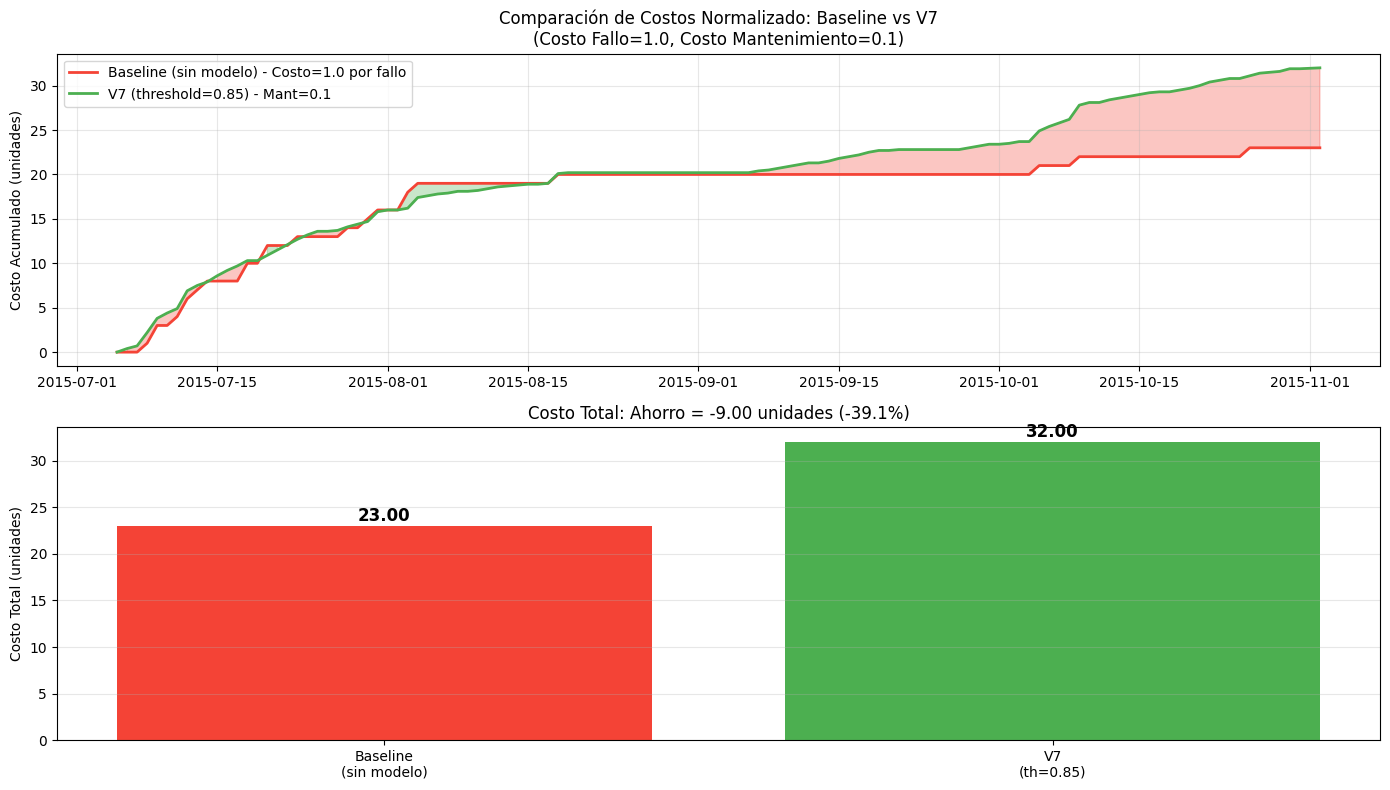


RESUMEN DE COSTOS NORMALIZADO
  Costo por fallo no atendido: 1.0
  Costo por mantenimiento preventivo: 0.1
  Total fallos reales: 23
  Total mantenimientos predichos: 230
  Fallos detectados (TP): 14
  Fallos no detectados (FN): 9
  Costo Baseline (sin modelo): 23.00
  Costo con Modelo: 32.00
  AHORRO: -9.00 (-39.1%)


In [ ]:
# Análisis de costos con valores normalizados
plot_cost_comparison_normalized_final(
    df=test_feat,
    y_pred=y_pred,
    y_true=y_test.values,
    cost_failure=1.0,
    cost_maintenance=0.1,
    model_name='Final',
    threshold=MODEL_CONFIG['threshold']
)